# 序列模型
## 统计工具
在时间t观察到$x_t$，那么得到T个不独立随机变量$(x_1,...,x_T) \sim p(x)$<br>
使用条件概率展开：$p(a, b) = p(a)p(b|a) = p(b)p(a|b)$
$$p(x) = p(x_1) \cdot p(x_2|x_1) \cdot p(x_3|x_1,x_2) ... p(x_T|x_1,...,x_T)$$
$$p(x) = p(x_T) \cdot p(x_{T-1}|x_T) \cdot p(x_{T-2}|x_T,x_{T-1}) ... p(x_1|x_2,...,x_T)$$
<img src='./image/statisticTool.jpg' alt='statisticTool' width=400><br>
对条件概率建模<br>
$$p(x_t|x_1,...,x_{t-1})=p(x_t|f(x_1,...,x_{t-1}))$$
对见过的数据建模，也称自回归模型(自回归就是说不想图片和标号那样是分开的，预测的就是给定的数据本身)<br>
给定前面的t-1个数据，预测第t个数据

## 方案A-马尔可夫假设
假设当前的数据只跟$\tau$个过去数据点有关<br>
$$p(x_t|x_1,...,x_{t-1}) = p(x_t|x_{t-\tau},...,x_{t-1}) = p(x_t|f(x_1,...,x_{t-1}))$$
例如在过去数据上训练一个MLP模型，输入是$\tau$个特征输出是需要预测的一个数据

## 方案B-潜变量模型
引入潜变量$h_t$来表示过去信息$h_t = f(x_1,...,x_{t-1})$<br>
这样$x_t = p(x_t|h)$<br>
<img src='./image/var.jpg' alt='var' width=400><br>

## 序列模型
使用马尔可夫假设构建模型<br>
给定任何一个时间点，预测接下来的点

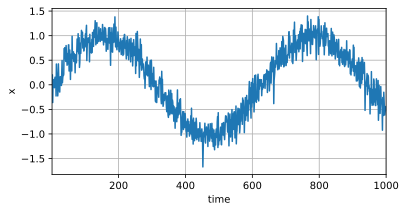

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

将数据映射为数据对$y_t = x_t 和 x_t=[x_{t-\tau},...,x_{t-1}]$

In [2]:
tau = 4
features = torch.zeros((T - tau, tau)) # 样本数，特征数
for i in range(tau):
    features[:, i] = x[i:T - tau + i] # 映射数据
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

一个拥有两个全连接层的多层感知机

In [3]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss()

In [4]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.069179
epoch 2, loss: 0.055321
epoch 3, loss: 0.047631
epoch 4, loss: 0.046145
epoch 5, loss: 0.049450


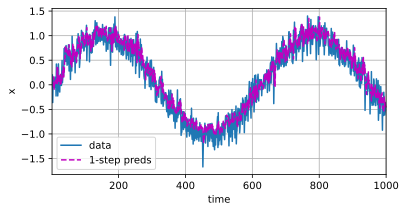

In [5]:
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

进行多步预测<br>
从600开始往后预测四百个点

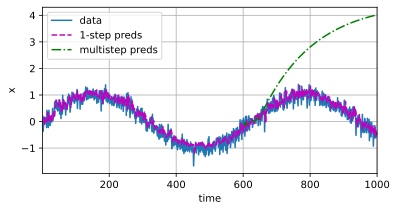

In [10]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]], [
    x.detach().numpy(),
    onestep_preds.detach().numpy(),
    multistep_preds[n_train + tau:].detach().numpy()], 'time', 'x',
         legend=['data', '1-step preds',
                 'multistep preds'], xlim=[1, 1000], figsize=(6, 3))

更仔细地看下一k步预测<br>
给定四个点预测后续k个点

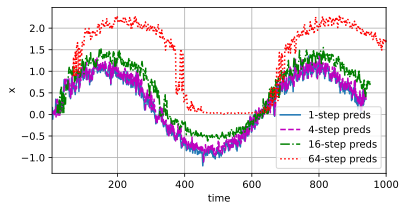

In [11]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]

for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time',
         'x', legend=[f'{i}-step preds'
                      for i in steps], xlim=[5, 1000], figsize=(6, 3))